# Submission score 0.4 (XGB model)

A grans trets:
1. No eliminem cap pacient (tot i que ho tenim preparat per fer proves eliminant pacient amb outlier de 500 de colesterol.
2. Passarem un Scaler a les variables continues (excepte Age, tot i que es podria probar si cambia algo) de Min/Max
3. Fem un dummies de les categoriques
4. La variable Age la passem a catgeorica de forma manual (pendent provar de fer una standaritacio com la resta)
5. Fem servir el model XGB per obtenir les features mes importants --> ens serveix a nivell indicatiu per comparar despres resultats amb Fetaure Engineering **X3**
6. Fem FeatureEngineering (senzill : apliquem el Polynomial). Podriem fer algo mes? Provem diferents tipus.
7. Fem feature selection, i obtenim resultats ajustant valor de threshold=0.01 (l'hem de posar a 0.009 per millorar).

### que podriem fer per millorar?
1. optimitzar model? Gridsearch?
2. es poden provar variant del feature engineering?


**Tests a fer submission: eliminar pacient 60, i posar el threshold a 0.009 --> dona un log_los de 0.26!!**

In [1]:
# Import essentials
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

The train values, train labels and test values are in different datasets, **we will load evrything and merge it together in the same dataframe (with label = NaN for the test)**. In that way, all the treatment (means, outliers, ...) we do would be considering the entire dataset

In [2]:
# load the csv
train_values_df = pd.read_csv('train_values.csv') # Load the `train` file
train_labels_df = pd.read_csv('train_labels.csv') # Load the `train` file
test_values_df = pd.read_csv('test_values.csv') # Load the `train` file
test_ids = test_values_df['patient_id']

de l'analisi dels histogrames hem vist que hi havien dues variables amb algunes diferencies entre train i test set:
1. serum_cholesterol_mg_per_dl
2. oldpeak_eq_st_depression

In [3]:
train_values_df[train_values_df['serum_cholesterol_mg_per_dl']>500]

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
60,rv6siv,2,reversible_defect,115,3,0,0,2,564,1.6,0,67,160,0


In [4]:
train_values_df[train_values_df['oldpeak_eq_st_depression'] > 5]

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
140,noxsnw,3,reversible_defect,140,4,0,0,0,217,5.6,1,55,111,1
162,usnkhx,3,reversible_defect,160,4,3,0,2,164,6.2,0,62,145,0


#### Provem d'eliminar pacients que te outlier amb serum de colesterol
hauriem de mirar si eliminant el de oldpeak tb millorem algo

train_values_df=train_values_df.drop([60])
train_labels_df=train_labels_df.drop([60])

merge and concat the dataframes in one (NaNs for the test label)

In [5]:
heart_df= pd.concat([pd.merge(train_values_df, train_labels_df, on='patient_id'), test_values_df], sort=False)
heart_df.head()

#store the original dimensions
len_train=train_values_df.shape[0]
len_test=test_values_df.shape[0]

Curiositat per l'edat, es veuen distribucions molt diferents?

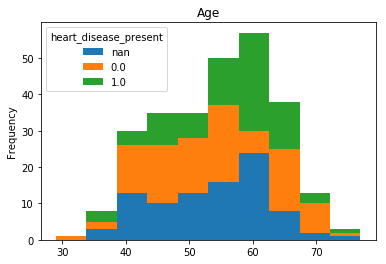

In [6]:
heart_df.pivot(columns='heart_disease_present').age.plot(kind = 'hist', bins=10, stacked=True)
plt.title('Age')
plt.show()

#### Pre-Processing: estandaritzem utilitzant el MinMaxScaler

In [7]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

heart_df['serum_cholesterol_mg_per_dl'] = min_max_scaler.fit_transform( np.array(heart_df['serum_cholesterol_mg_per_dl'].values).reshape(-1,1))
heart_df['max_heart_rate_achieved'] = min_max_scaler.fit_transform( np.array(heart_df['max_heart_rate_achieved'].values).reshape(-1,1))
heart_df['oldpeak_eq_st_depression'] = min_max_scaler.fit_transform( np.array(heart_df['oldpeak_eq_st_depression'].values).reshape(-1,1))
heart_df['resting_blood_pressure'] = min_max_scaler.fit_transform( np.array(heart_df['resting_blood_pressure'].values).reshape(-1,1))

#### Categoritzem les edats
Podriem probar de fer un MinMAx tb...

In [8]:
# en aquest bloc definim una columna categoritzant les edats
bins= [20,30,40,50,60,70,80]
labels = ['20-29','30-39','40-49','50-59','60-69','70-79']
heart_df['AgeGroup'] = pd.cut(heart_df['age'], bins=bins, labels=labels, right=False)
del heart_df['age']
pd.value_counts(heart_df['AgeGroup'])

50-59    107
60-69     74
40-49     67
30-39     11
70-79     10
20-29      1
Name: AgeGroup, dtype: int64

##### utilitzem funcio Dummies per resta variables i la nova d'age

In [9]:
heart_df_D=pd.get_dummies(heart_df, columns=['AgeGroup','thal','slope_of_peak_exercise_st_segment','chest_pain_type','num_major_vessels','resting_ekg_results','exercise_induced_angina','fasting_blood_sugar_gt_120_mg_per_dl'])
heart_df_D.head()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,max_heart_rate_achieved,heart_disease_present,AgeGroup_20-29,AgeGroup_30-39,AgeGroup_40-49,...,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,resting_ekg_results_0,resting_ekg_results_1,resting_ekg_results_2,exercise_induced_angina_0,exercise_induced_angina_1,fasting_blood_sugar_gt_120_mg_per_dl_0,fasting_blood_sugar_gt_120_mg_per_dl_1
0,0z64un,0.320755,0.415525,0.000000,1,0.755725,0.0,0,0,1,...,0,0,0,0,0,1,1,0,1,0
1,ryoo3j,0.150943,0.200913,0.258065,0,0.664122,0.0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2,yt1s1x,0.292453,0.406393,0.000000,1,0.694656,1.0,0,0,0,...,0,0,1,0,0,1,0,1,1,0
3,l2xjde,0.547170,0.221461,0.000000,1,0.839695,1.0,0,0,1,...,0,0,0,1,0,0,1,0,1,0
4,oyt4ek,0.792453,0.328767,0.677419,1,0.564885,0.0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


#### El primer sera veure el XGB classifier si funciona be o no, tal qual

In [10]:
# seleccionem les features que utilitzarem, important eliminar patient_id i heart_disease
features_D = heart_df_D.columns.tolist()
features_D.remove('heart_disease_present')
features_D.remove('patient_id')

# load data
df_Heart_train=heart_df_D[:len_train]
df_Heart_test=heart_df_D[len_train:]
X=df_Heart_train[features_D]
y=df_Heart_train['heart_disease_present']

In [11]:
# k-fold cross validation evaluation of xgboost model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from xgboost import plot_importance

# CV model
model = XGBClassifier(colsample_bytree=0.1,n_estimators=500, reg_lambda=1, learning_rate=0.09, min_child_weight = 2, max_depth = 8, gamma=2, subsample=.2,scale_pos_weight = 1, eval_metric='logloss',reg_alpha=0.00001)
kfold = KFold(n_splits=10, random_state=7)

results = cross_val_score(model, X, y, cv=kfold, scoring='neg_log_loss', )
print("Log loss: %.2f%% (%.2f%%)" % (results.mean(), results.std()))

Log loss: -0.41% (0.09%)


Els reusltats no son dolents, amb un log loss al voltant de 0.43.... pero hem de millorar!!!

#### Feature Importance using Gradient Boosting
Fem un primer test de com es tracta en el Gradient Boosting el Feature Importance.
Basicament apliquem el model sobre les dades, i despres utilitzam el plot_importance del mateix xgboost per veure classificacio features mes important.
L'analisi no es senzill, i de fet pots veure diferents tipus d'importancies (no ho acabo de pillar). el mes interessant es que aixo ens permetra seleccionar features en funcio d'un threshold, i aixo ens permetrà veure resultast de models diferents optimitzant les features seleccionades

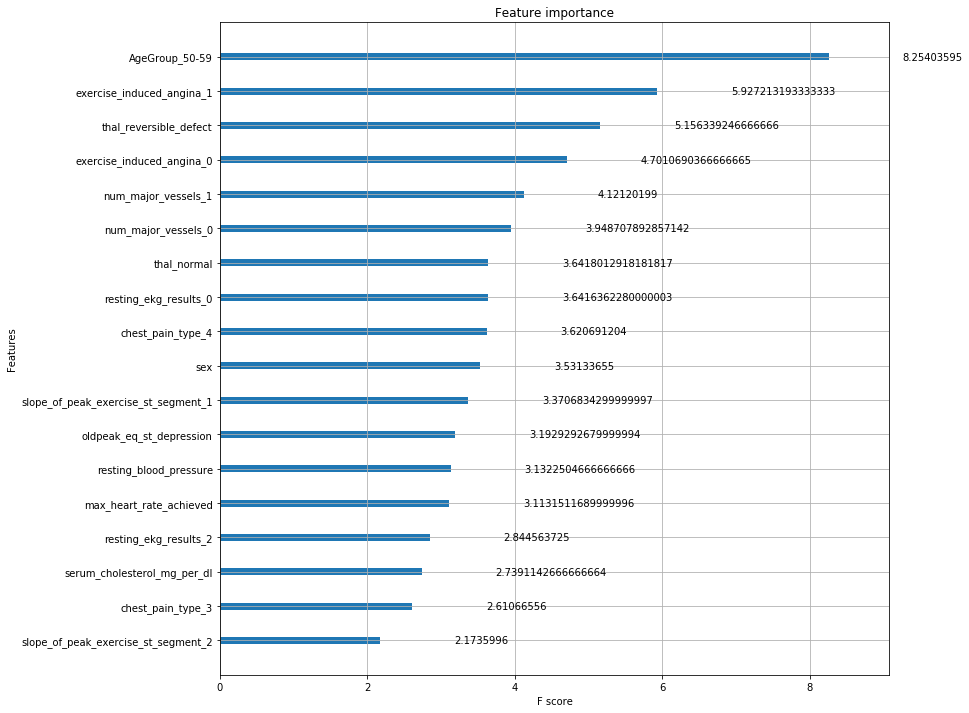

In [12]:
# plot feature importance using built-in function
#!pip install xgboost



# fit model no training data
model.fit(X, y)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=34);
plt.show()

Aqui ja es veuen coses interessants, pero es dificil triar de forma manual a partir de quin fetaure tindrem millors resultats.
utilitzarem eines del model per fer aquesta seleccio...

#### Aqui fem el Preprocessing i generem arrays que farem servir pel model despres

In [13]:
import sklearn.preprocessing as preproc

# Create pairwise interaction features, skipping the constant bias term
X2_train = preproc.PolynomialFeatures(include_bias=False).fit_transform(X)
X2b_train = preproc.PolynomialFeatures(include_bias=True).fit_transform(X)
X3_train = preproc.PolynomialFeatures(interaction_only=True, degree=2).fit_transform(X)

print (X.shape)
print (X2_train.shape)
print (X3_train.shape)

(180, 32)
(180, 560)
(180, 529)


#### Feature Engineering and Reduction:
Aqui comença la part xula: ara aplicarem el model (ja definit abans), sobre els datasets modificats (Polynomial fetaures), a la vegada que seleccionem nomes les fetaures que estiguin per sobre d'un llindar.

Aqui, el llindar que marca el **threshold es molt sensible**: petites variacions optimitzen resultats!

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel


# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X3_train, y, test_size=0.2, random_state=10)

# select features using threshold
model.fit(X_train,y_train)
selection = SelectFromModel(model, threshold=0.009, prefit=True)
select_X_train = selection.transform(X_train)

# train model
selection_model = XGBClassifier(colsample_bytree=0.1,n_estimators=600, reg_lambda=1, learning_rate=0.095, min_child_weight = 2, max_depth = 4, gamma=1.8, subsample=.2,scale_pos_weight = 1, eval_metric='logloss',reg_alpha=0.00001)
selection_model.fit(select_X_train, y_train)

# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
y_proba = selection_model.predict_proba(select_X_test)

La primera submission esta feta amb threshold de 0.01, pero he vist que amb 0.009 encara millora 2 decimes, provar-ho demà

##### Aqui validem els resultats i mirem quin accuracy i log_score tenim

In [116]:
from sklearn.metrics import accuracy_score, log_loss

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

logi = log_loss(y_test, y_proba)
print(logi)

0.8888888888888888
0.3086694294793738


Els resultats son molt bons, en alguns casos estem a voltant de correlacions de 0.86-88 i log-log de 0.26. Hem de veure si a drivendata aixo ens permet arribar a 0.3.

#### Preparem el model per la submission

In [120]:
del selection, selection_model, select_X_test, X_test

NameError: name 'selection_model' is not defined

Preparem les dades de test igual que hem fet amb les de training (polynomial feature)

In [122]:
X_test=df_Heart_test.drop(columns=['patient_id','heart_disease_present'])
X2_test = preproc.PolynomialFeatures(include_bias=False).fit_transform(X_test)
X3_test = preproc.PolynomialFeatures(interaction_only=True, degree=2).fit_transform(X_test)

#### Entrenem model, fem feature selection i fem una prediccio

In [123]:
# model fit
model.fit(X3_train,y)

# feature selection
selection = SelectFromModel(model, threshold=0.009, prefit=True)
select_X = selection.transform(X3_train)

# train model
selection_model =XGBClassifier(colsample_bytree=0.1,n_estimators=600, reg_lambda=1, learning_rate=0.095, min_child_weight = 2, max_depth = 4, gamma=1.8, subsample=.2,scale_pos_weight = 1, eval_metric='logloss',reg_alpha=0.00001)
selection_model.fit(select_X, y)

# eval model
select_X_test = selection.transform(X3_test)
y_pred = selection_model.predict(select_X_test)
y_proba = selection_model.predict_proba(select_X_test)

#### preparem submission

In [124]:
targets = train_labels_df['heart_disease_present'].unique()
predictions = pd.DataFrame()
# Record each prediction for each class as a separate column
for j in range(len(targets)):
    predictions[j] = y_proba[:,j]
    
# Add needed information for predictions 
predictions['patient_id'] = test_ids

# Find the class and associated probability
predictions['heart_disease_present'] = predictions[targets].idxmax(axis = 1)
predictions['confidence'] = predictions[targets].max(axis = 1)

submission= predictions[['patient_id',1]]
submission.columns = ['patient_id','heart_disease_present']

In [125]:
submission.to_csv('Pablo_submission8.csv',index=False)